# [AST: Audio Spectrogram Transformer](https://www.isca-speech.org/archive/interspeech_2021/gong21b_interspeech.html)

This colab script contains the implementation of a minimal demo of pretrained Audio Spectrogram Transformer (AST) inference and attention visualization.

This script is self-contained and can be run in one click, replace the `sample_audio_path` to test your own audio.

Please cite our paper if you find this repository useful.

```
@inproceedings{gong21b_interspeech,
  author={Yuan Gong and Yu-An Chung and James Glass},
  title={{AST: Audio Spectrogram Transformer}},
  year=2021,
  booktitle={Proc. Interspeech 2021},
  pages={571--575},
  doi={10.21437/Interspeech.2021-698}
}
```
For more information, please check https://github.com/YuanGongND/ast

## Step 1. Install and import required packages.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd 'drive/MyDrive/Colab Notebooks/SED/AST'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/SED/AST


In [1]:
ls

ast/  AST_Inference_Demo_CPU.ipynb  use.sh*  venv/


In [2]:
# import sys
# if 'google.colab' in sys.modules:
#     print('Running in Colab.')
#     !git clone https://github.com/YuanGongND/ast
#     sys.path.append('./ast')
# #%cd ./ast/

# ! pip install timm==0.4.5
# ! pip install wget
import os, csv, argparse, wget
os.environ['TORCH_HOME'] = './ast/pretrained_models'
if os.path.exists('./ast/pretrained_models') == False:
  os.mkdir('./ast/pretrained_models')
import torch, torchaudio, timm
import numpy as np
from torch.cuda.amp import autocast
import IPython

In [3]:
!pip list

Package                  Version
------------------------ ----------
anyio                    3.6.2
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
arrow                    1.2.3
asttokens                2.2.1
attrs                    22.2.0
backcall                 0.2.0
beautifulsoup4           4.11.2
bleach                   6.0.0
certifi                  2022.12.7
cffi                     1.15.1
charset-normalizer       3.0.1
comm                     0.1.2
cycler                   0.11.0
debugpy                  1.6.6
decorator                5.1.1
defusedxml               0.7.1
executing                1.2.0
fastjsonschema           2.16.2
fqdn                     1.5.1
idna                     3.4
importlib-metadata       6.0.0
importlib-resources      5.12.0
ipykernel                6.21.2
ipython                  8.10.0
ipython-genutils         0.2.0
ipywidgets               8.0.4
isoduration              20.11.0
jedi                     0.18.2
Jinja2           

## Step 2. Create AST model and load AudioSet pretrained weights.
The pretrained model achieves 45.93 mAP on the AudioSet evaluation set, which is the best single model in the paper. 

In [4]:
%cd ./ast

/home/milad/milad/1/TEZ/2sed-ast/ast


In [5]:
ls

'AST_ Audio Spectrogram Transformer _ Papers With Code.pdf'
 ast.png
 colab/
 egs/
 LICENSE
 pretrained_models/
 README.md
 requirements.txt
 src/


In [8]:
from src.models import ASTModel

# Create a new class that inherits the original ASTModel class
class ASTModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.v.blocks:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list

def make_features(wav_name, mel_bins, target_length=1024):
    waveform, sr = torchaudio.load(wav_name)
    assert sr == 16000, 'input audio sampling rate must be 16kHz'

    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]

    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    fbank = (fbank - (-4.2677393)) / (4.5689974 * 2)
    return fbank


def load_label(label_csv):
    with open(label_csv, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        lines = list(reader)
    labels = []
    ids = []  # Each label has a unique id such as "/m/068hy"
    for i1 in range(1, len(lines)):
        id = lines[i1][1]
        label = lines[i1][2]
        ids.append(id)
        labels.append(label)
    return labels

# Create an AST model and download the AudioSet pretrained weights
audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
if os.path.exists('./pretrained_models/audio_mdl.pth') == False:
  wget.download(audioset_mdl_url, out='./pretrained_models/audio_mdl.pth')

# Assume each input spectrogram has 1024 time frames
input_tdim = 1024
checkpoint_path = './pretrained_models/audio_mdl.pth'
# now load the visualization model
ast_mdl = ASTModelVis(label_dim=527, input_tdim=input_tdim, imagenet_pretrain=False, audioset_pretrain=False)
print(f'[*INFO] load checkpoint: {checkpoint_path}')
checkpoint = torch.load(checkpoint_path, map_location='cpu')#'cuda')
audio_model = torch.nn.DataParallel(ast_mdl, device_ids=[0])
audio_model.load_state_dict(checkpoint)
audio_model = audio_model.to(torch.device('cpu'))#("cuda:0"))
audio_model.eval()          

# Load the AudioSet label set
label_csv = './egs/audioset/data/class_labels_indices.csv'       # label and indices for audioset data
labels = load_label(label_csv)

---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212
[*INFO] load checkpoint: ./pretrained_models/audio_mdl.pth


In [9]:
labels[:10], len(labels)

(['Speech',
  'Male speech, man speaking',
  'Female speech, woman speaking',
  'Child speech, kid speaking',
  'Conversation',
  'Narration, monologue',
  'Babbling',
  'Speech synthesizer',
  'Shout',
  'Bellow'],
 527)

In [10]:
print(audio_model)

DataParallel(
  (module): ASTModelVis(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): Dropout(

## Step 3. Load an audio and predict the sound class.
By default we test one sample from another dataset (VGGSound) that has not been seen during the model training.

For this very specific sample, it is a parrot mimicing human speech and there's a bird chirp in the middle, that's why the model predicts it is a mixture of speech and bird sound. This audio is extracted from a Youtube video, and the video looks like this (note: only audio is used for prediction): 

Replace the `sample_audio_path` to test your own audio.

In [2]:
! sudo apt-get install sox 

[sudo] password for milad: 


In [15]:
# gunshot sample
! sox './sample_audios/18ak.wav' -r 16000 './sample_audios/18ak-16k.wav'

sox WARN rate: rate clipped 100 samples; decrease volume?
sox WARN dither: dither clipped 81 samples; decrease volume?


In [ ]:
# gunshot sample
! sox './sample_audios/17ak.wav' -r 16000 './sample_audios/17ak-16k.wav'

In [ ]:
!sox ./sample_audios/designed-fire-winds-swoosh-04-116788.mp3 -r 16000 ./sample_audios/designed-fire-winds-swoosh-04-1167881.mp3

In [16]:
!ls -allh ./sample_audios

total 17M
drwxrwxr-x 3 milad milad 4.0K فوریه 23 11:13  .
drwxrwxr-x 8 milad milad 4.0K فوریه 23 11:16  ..
-rw-rw-r-- 1 milad milad 157K نوْوام 14 03:10  1-172649-C-401.wav
-rw-rw-r-- 1 milad milad 431K نوْوام 13 03:06  1-172649-C-40.wav
-rw-rw-r-- 1 milad milad 157K نوْوام 14 03:07  1-34094-B-51.wav
-rw-rw-r-- 1 milad milad 431K نوْوام 13 03:07  1-34094-B-5.wav
-rw-rw-r-- 1 milad milad 126K فوریه 20 23:55  17ak-16k.wav
-rw-rw-r-- 1 milad milad 345K فوریه 20 22:04  17ak.wav
-rw-rw-r-- 1 milad milad 126K فوریه 23 11:17  18ak-16k.wav
-rw-rw-r-- 1 milad milad 376K فوریه 20 22:04  18ak.wav
-rw-rw-r-- 1 milad milad 157K نوْوام 14 03:12  audio_2-74977-A-181.wav
-rw-rw-r-- 1 milad milad 431K نوْوام 13 03:04  audio_2-74977-A-18.wav
-rw-rw-r-- 1 milad milad 157K نوْوام 14 03:14  audio_3-120644-A-121.wav
-rw-rw-r-- 1 milad milad 431K نوْوام 13 03:06  audio_3-120644-A-12.wav
-rw-rw-r-- 1 milad milad 157K نوْوام 14 03:21  audio_3-151081-B-201.wav
-rw-rw-r-- 1 milad milad 431K نوْوام 13 03:04  audi

In [ ]:
# downlaod sample audio
# change url to play with the script
#sample_audio_path = 'https://www.dropbox.com/s/kx8s8irzwj6nbeq/glLQrEijrKg_000300.flac?dl=1'

# # some other samples
# sample_audio_path = 'https://www.dropbox.com/s/vddohcnb9ane9ag/LDoXsip0BEQ_000177.flac?dl=1'
#sample_audio_path = 'https://www.dropbox.com/s/omned2muw8cyunf/6jiO0tPLK7U_000090.flac?dl=1'

# if os.path.exists('./sample_audios') == False:
#   os.mkdir('./sample_audios')
# if os.path.exists('./sample_audios/sample_audio.flac') == True:
#   os.remove('./sample_audios/sample_audio.flac')
# wget.download(sample_audio_path, './sample_audios/sample_audio.flac')

In [17]:
%%time
# Get a sample audio and make feature for predict
sample_path = './sample_audios/18ak-16k.wav'
feats = make_features(sample_path, mel_bins=128)           # shape(1024, 128)
feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
feats_data = feats_data.to(torch.device('cpu'))#("cuda:0"))
# do some masking of the input
#feats_data[:, :512, :] = 0.

# Make the prediction
with torch.no_grad():
  with autocast():
    output = audio_model.forward(feats_data)
    output = torch.sigmoid(output)
result_output = output.data.cpu().numpy()[0]
sorted_indexes = np.argsort(result_output)[::-1]

# Print audio tagging top probabilities
print('Predice results:')
for k in range(10):
    print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))
print('Listen to this sample: ')
IPython.display.Audio(sample_path)

/home/milad/milad/1/TEZ/2sed-ast/venv/lib/python3.8/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Predice results:
- Machine gun: 0.7062
- Gunshot, gunfire: 0.5423
- Artillery fire: 0.2206
- Sound effect: 0.0404
- Speech: 0.0315
- Explosion: 0.0279
- Vehicle: 0.0255
- Burst, pop: 0.0176
- Helicopter: 0.0121
- Fusillade: 0.0119
Listen to this sample: 
CPU times: user 7.17 s, sys: 1.15 s, total: 8.32 s
Wall time: 6.31 s


In [18]:
# Get a sample audio and make feature for predict
feats = make_features('./sample_audios/sample_audio.flac', mel_bins=128)           # shape(1024, 128)
feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
feats_data = feats_data.to(torch.device('cpu'))#("cuda:0"))

# do some masking of the input
#feats_data[:, :512, :] = 0.

# Make the prediction
with torch.no_grad():
  with autocast():
    output = audio_model.forward(feats_data)
    output = torch.sigmoid(output)
result_output = output.data.cpu().numpy()[0]
sorted_indexes = np.argsort(result_output)[::-1]

# Print audio tagging top probabilities
print('Predice results:')
for k in range(10):
    print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))
print('Listen to this sample: ')
IPython.display.Audio('./sample_audios/sample_audio.flac')

Predice results:
- Speech: 0.7290
- Music: 0.4518
- Basketball bounce: 0.1454
- Run: 0.0892
- Male speech, man speaking: 0.0802
- Outside, urban or manmade: 0.0731
- Narration, monologue: 0.0346
- Crowd: 0.0169
- Inside, public space: 0.0155
- Hubbub, speech noise, speech babble: 0.0136
Listen to this sample: 


In [19]:
%%time
# Make the prediction
with torch.no_grad():
  with autocast():
    output = audio_model.forward(feats_data)
    output = torch.sigmoid(output)
result_output = output.data.cpu().numpy()[0]
sorted_indexes = np.argsort(result_output)[::-1]

# Print audio tagging top probabilities
print('Predice results:')
for k in range(1):
    print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))

Predice results:
- Speech: 0.7290
CPU times: user 7.03 s, sys: 1.09 s, total: 8.13 s
Wall time: 5.16 s


## Step 4.a. Visualize the mean attention map of all attention heads for each layer
Note the model focuses on the middle high frequency bird chirp as well as the low frequency speech.

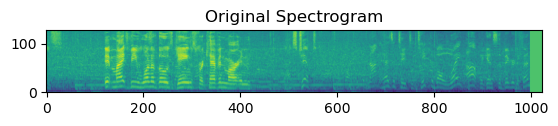

/home/milad/milad/1/TEZ/2sed-ast/venv/lib/python3.8/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


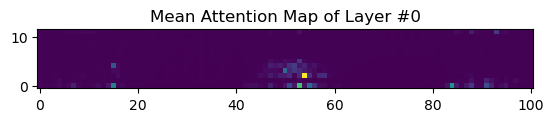

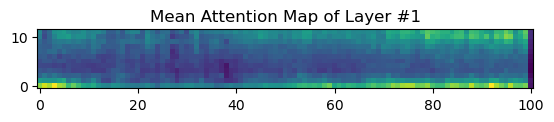

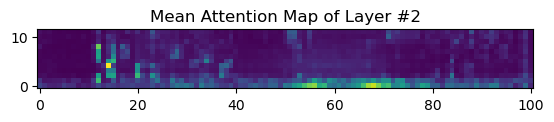

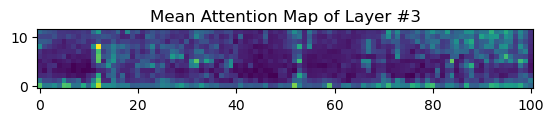

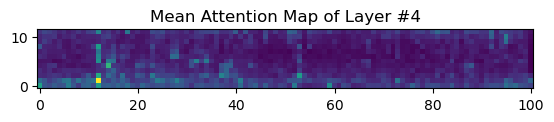

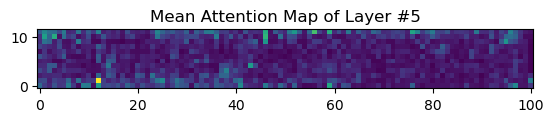

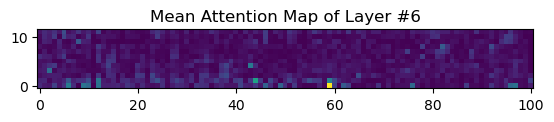

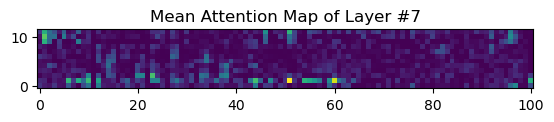

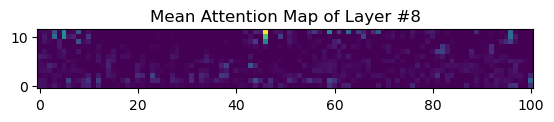

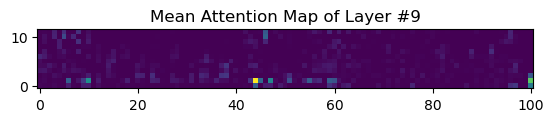

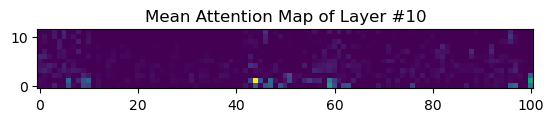

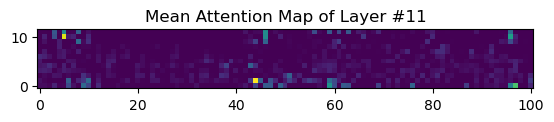

In [20]:
from matplotlib import pyplot as plt
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)
for i in range(len(att_list)):
  att_list[i] = att_list[i].data.cpu().numpy()
  att_list[i] = np.mean(att_list[i][0], axis=0)
  att_list[i] = np.mean(att_list[i][0:2], axis=0)
  att_list[i] = att_list[i][2:].reshape(12, 101)
  plt.imshow(att_list[i], origin='lower')
  plt.title('Mean Attention Map of Layer #{:d}'.format(i))
  plt.show()
  plt.close()

## Step 4.b. Visualize the attention map of each attention head of a specific layer
Note the attention map of heads are quite diverse.

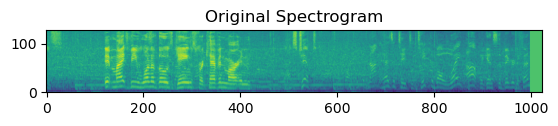

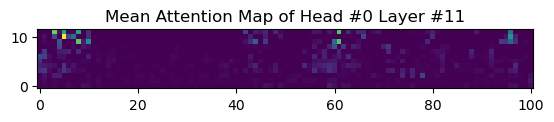

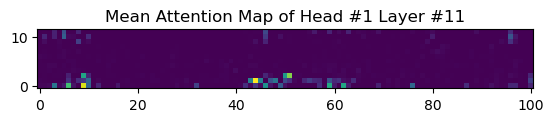

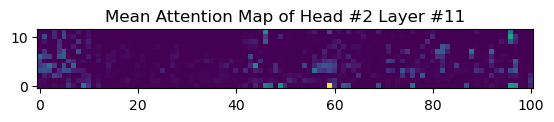

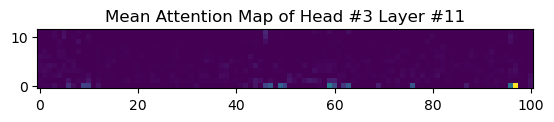

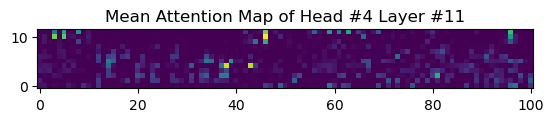

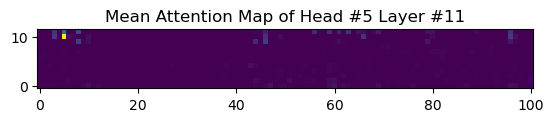

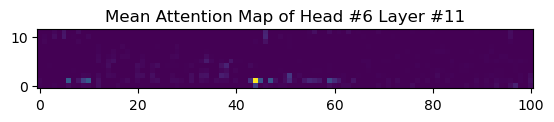

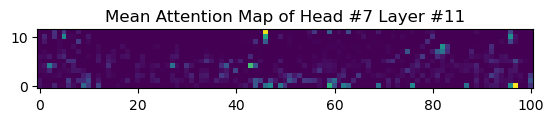

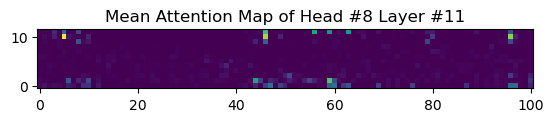

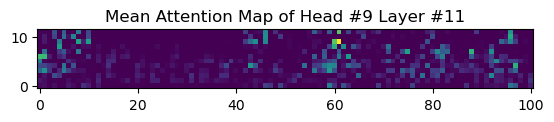

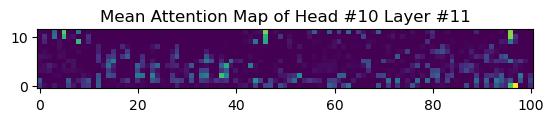

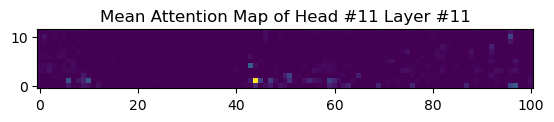

In [21]:
from matplotlib import pyplot as plt
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)

# the layer of interest
i = 11

att_map = att_list[i].data.cpu().numpy()
att_map = att_map[0]
att_map = np.mean(att_map[:, 0:2, :], axis=1)
att_map = att_map[:, 2:].reshape(12, 12, 101)
for j in range(12):
  plt.imshow(att_map[j], origin='lower')
  plt.title('Mean Attention Map of Head #{:d} Layer #{:d}'.format(j, i))
  plt.show()
  plt.close()